![img](https://miro.medium.com/max/802/1*u7swL7CrX0UW_lIScu1eDQ.png)
# 1B. Introduction to Machine Learning with H2O-3-regression

In this tutorial we will use the subset of the Freddie Mac Single-Family dataset to try to predict the interest rate for a loan using H2O's XGBoost and Deep Learning models. We will explore how to use these models for a regression problem, and we will also demonstrate how to use H2O's grid search to tune the hyper-parameters of both models.

### Installations

In [1]:
# installing java
! apt-get install default-jre
! java -version
# install h2o
! pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 164.8MB 74kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.2-py2.py3-none-any.whl size=164848811 sha256=7342314c3d6b6a6ca1d276daa56a46a457888b658040497b22d21abbf96b2720
  Stored in directory: /root/.cache/pip/wheels/37/b6/c7/c1cfdcd471d476b2b5129f4d27a0fd89043858ee74eda7ee7a
Successfully built h2o


### Task 1: Init

In [2]:
#Import H2O and other libaries that will be used in this tutorial 
import h2o
from h2o.estimators import *
from h2o.grid import *

We now have to initialize our instance. If you are on Aquarium, it will connect to a local instance; if you are on your own machine, it will launch an instance connected to your machine.

In [3]:
import os

startup  = '/home/h2o/bin/aquarium_startup'
shutdown = '/home/h2o/bin/aquarium_stop'

if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
else:
    local_url = 'http://localhost:54321'
    aquarium = False

In [4]:
h2o.init(url = local_url)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpkwg2kpy_
  JVM stdout: /tmp/tmpkwg2kpy_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpkwg2kpy_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,23 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_unknownUser_mp3kzw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
#Import the dataset from an AWS instance 
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Task 2: Regression Concepts

Regression ► Regression tries to predict a continuous number (as opposed to classification, which only categorizes). With a regressor model, you try to predict the exact number from your response column. In our case, we will try to predict the interest rate (a continuous value). You will see later on that some samples might have a 7.5% interest rate, and our regression model will try to predict that number.

Some metrics:

*   MSE ► measures the average of the squares of the errors or deviations. MSE takes the distances from the points to the regression line (these distances are the "errors") and squaring them to remove any negative signs. MSE incorporates both the variance and the bias of the predictor. MSE also gives more weight to larger differences.

*   RMSE ► evaluates how well a model can predict a continuous value. The RMSE units are the same as the predicted target, which is useful for understanding if the size of the error is of concern or not, but is sensitive to outliers.

*   MAE ► is an average of the absolute errors. The MAE units are the same as the predicted target as well as the RMSW, which is also useful for understanding whether the size of the error is of concern or not.

For a detailed description of the other metrics, please check: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html#evaluation-model-metrics

Based-Tree Algorithms:

*   Decision Trees ► uses a tree-like model of decisions to make a prediction. Decision trees subdivide the dataset and move event outcomes left and right to build the tree model and fit all the data. The series of questions are generated automatically to optimize the separation of the data points depending on what you are trying to find whether you are doing a regression or classification tree. (non-linear / correlated features doe not eaffect their performance / robust to missing values)

*   Tree Ensembles ► combine several decision trees in order to solve the same problem and make better predictions. One example of tree ensembles is Random Forest, which uses bagging or bootstrap aggregation, meaning we fit many different trees on different samples of the data.

*   XGBoost ► another decision-tree-based ensemble that uses boosting to yield accurate models, XGBoost provides parallel tree boosting (also known as GBDT, GBM) that solves many data science problems in a fast and accurate manner. For many problems, XGBoost is one of the best GBM frameworks today.

*   Deep Learning ► is a subset of machine learning that uses neural networks to solve complex problems that other machine learning algorithms have difficulties with, such as image classification, speech recognition, etc. Deep Learning models have an advantage over standard machine learning because they are very effective at learning non-linear derived features from the input features. Neural networks are algorithms based on how the human brain works because they are composed of nodes or commonly known as "neurons," and thus the name of neural networks.
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#deep-learning-neural-networks


### Task 3: Start Experiment

In [6]:
# First 10 dtaset rows
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


In [7]:
# Some descriptive analytics values
loan_level["ORIGINAL_INTEREST_RATE"].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.182686863799322
maxs,11.5
sigma,0.5799408623980744
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


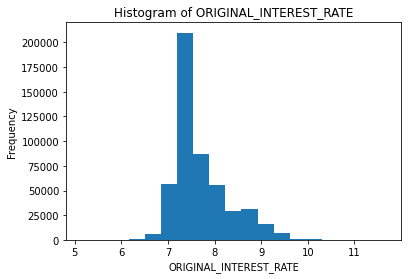

In [8]:
loan_level["ORIGINAL_INTEREST_RATE"].hist()

In [9]:
# Spliting data into Training, validation and test.
train, valid, test = loan_level.split_frame([0.70, 0.15], seed = 42)
print("train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows))

train:350268 valid:74971 test:74898


In [10]:
# Choose your y variable response, and the x variable or predictor
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))

### Task 4: Build an XGBoost Model

In [11]:
# Build and train the model
xgb = H2OXGBoostEstimator(seed = 42, 
                          model_id = 'XGBoost', 
                          nfolds = 0, 
                          keep_cross_validation_predictions = False)

%time xgb.train(x = x, y = y, training_frame = train, validation_frame = valid)

xgboost Model Build progress: |███████████████████████████████████████████| 100%
CPU times: user 660 ms, sys: 59.9 ms, total: 720 ms
Wall time: 31.4 s


In [12]:
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.17744636323081306
RMSE: 0.4212438287154045
MAE: 0.30712844420662655
RMSLE: 0.04987056256391179
Mean Residual Deviance: 0.17744636323081306

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.18013989282125126
RMSE: 0.4244289019626859
MAE: 0.3108204587914598
RMSLE: 0.0503052982338251
Mean Residual Deviance: 0.18013989282125126

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-04-30 16:57:36,0.206 sec,0.0,6.708863,6.683679,45.008844,6.704750,6.679805,44.953673
1,,2021-04-30 16:57:38,2.569 sec,1.0,4.710473,4.678698,22.188559,4.707354,4.675791,22.159185
2,,2021-04-30 16:57:39,3.289 sec,2.0,3.316827,3.275220,11.001343,3.313931,3.272599,10.982141
3,,2021-04-30 16:57:39,3.986 sec,3.0,2.348813,2.292739,5.516923,2.346267,2.290480,5.504970
4,,2021-04-30 16:57:40,4.681 sec,4.0,1.681035,1.605171,2.825880,1.678602,1.603109,2.817706
5,,2021-04-30 16:57:44,8.788 sec,12.0,0.467832,0.329612,0.218867,0.467097,0.330447,0.218179
6,,2021-04-30 16:57:48,12.988 sec,20.0,0.442830,0.324432,0.196099,0.442941,0.325974,0.196197
7,,2021-04-30 16:57:54,18.374 sec,30.0,0.433406,0.316909,0.187840,0.434432,0.319212,0.188731
8,,2021-04-30 16:58:01,25.367 sec,43.0,0.425616,0.310474,0.181149,0.427974,0.313689,0.183162
9,,2021-04-30 16:58:05,29.796 sec,50.0,0.421244,0.307128,0.177446,0.424429,0.310820,0.180140



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,"SELLER_NAME.NORWESTMORTGAGE,INC",25657.996094,1.000000,0.239125
1,OCCUPANCY_STATUS.I,7086.139160,0.276177,0.066041
2,ORIGINAL_UPB,6440.511230,0.251014,0.060024
3,ORIGINAL_LOAN_TO_VALUE,5813.790527,0.226588,0.054183
4,LOAN_PURPOSE.P,4025.863281,0.156905,0.037520
5,CREDIT_SCORE,3827.817139,0.149186,0.035674
6,"SERVICER_NAME.ABNAMROMTGEGROUP,INC",3514.124512,0.136960,0.032751
7,SELLER_NAME.COUNTRYWIDE,3313.306641,0.129133,0.030879
8,SELLER_NAME.NATLCITYMTGECO,3025.856445,0.117930,0.028200
9,SELLER_NAME.CROSSLANDMTGECORP,2976.497314,0.116007,0.027740



See the whole table with table.as_data_frame()


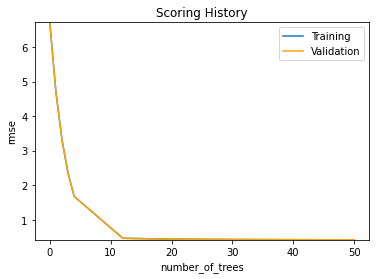

In [13]:
# plot the scoring history.
xgb.plot()

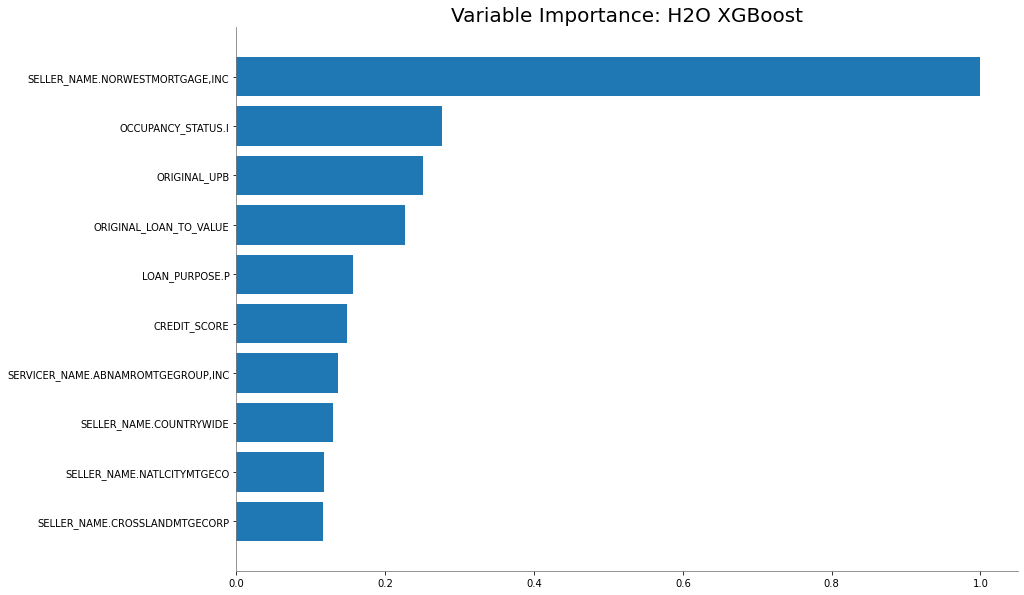

In [14]:
# variable importance plot.
xgb.varimp_plot()

In [15]:
# Some predictions on the validation set.
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.cbind(valid['ORIGINAL_INTEREST_RATE'])

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,ORIGINAL_INTEREST_RATE
7.20097,5.875
6.87724,6.75
7.0235,7.75
7.25526,6.625
7.02648,6.75
7.38137,7
6.8168,7
7.40214,7
7.06643,7.25
7.00728,7


In [16]:
# Save model performance.
default_xgb_per = xgb.model_performance(valid)

### Task 5: Build a Deep Learning Model

Deep learning models are not reproducible, meaning they won't yield the same result every time you run the same experiment.

In [17]:
#  Model deffinition and training
dl = H2ODeepLearningEstimator(seed = 42,
                              model_id = 'DL',
                              nfolds = 0,
                              keep_cross_validation_predictions = False)

% time dl.train(x = x, y = y, training_frame = train, validation_frame = valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 3.94 s, sys: 376 ms, total: 4.31 s
Wall time: 7min


In [18]:
# Summary
dl

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 73,601 weights/biases, 880.4 KB, 3,503,762 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,165,Input,0,,,,,,,,,
1,,2,200,Rectifier,0,0,0,0.0551267,0.213429,0,-0.019914,0.193277,-0.117529,0.278272
2,,3,200,Rectifier,0,0,0,0.0422807,0.0435792,0,-0.0501644,0.141325,-0.254044,0.499207
3,,4,1,Linear,,0,0,0.00110027,0.000851988,0,0.00918025,0.0943801,1.40214,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.1994304063383255
RMSE: 0.44657631636521605
MAE: 0.34133846963631276
RMSLE: 0.05347288548361901
Mean Residual Deviance: 0.1994304063383255

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.20441911789766326
RMSE: 0.45212732487393775
MAE: 0.34571533691103307
RMSLE: 0.054063769387322255
Mean Residual Deviance: 0.20441911789766326

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2021-04-30 17:06:13,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-04-30 17:06:19,14.537 sec,1535 obs/sec,0.026563,1,9304.0,0.542555,0.294366,0.408649,0.104016,0.543801,0.295719,0.409676,0.114307
2,,2021-04-30 17:07:40,1 min 32.262 sec,5990 obs/sec,1.349484,50,472681.0,0.475668,0.226260,0.341072,0.311315,0.474466,0.225118,0.341022,0.325762
3,,2021-04-30 17:08:29,2 min 21.359 sec,7307 obs/sec,2.568505,95,899665.0,0.484704,0.234938,0.346096,0.284902,0.486144,0.236336,0.347446,0.292162
4,,2021-04-30 17:09:18,3 min 10.565 sec,7930 obs/sec,3.784131,140,1325460.0,0.470214,0.221102,0.340018,0.327017,0.471495,0.222307,0.341060,0.334178
5,,2021-04-30 17:10:10,4 min 2.560 sec,8585 obs/sec,5.246003,194,1837507.0,0.475484,0.226085,0.334421,0.311848,0.476897,0.227431,0.336599,0.318834
6,,2021-04-30 17:11:02,4 min 54.521 sec,8895 obs/sec,6.625178,245,2320588.0,0.458787,0.210485,0.332989,0.359330,0.462518,0.213923,0.336567,0.359290
7,,2021-04-30 17:11:54,5 min 46.306 sec,9203 obs/sec,8.082740,299,2831125.0,0.450636,0.203072,0.326830,0.381894,0.453323,0.205501,0.330724,0.384513
8,,2021-04-30 17:12:45,6 min 37.434 sec,9503 obs/sec,9.596563,355,3361369.0,0.446576,0.199430,0.341338,0.392979,0.452127,0.204419,0.345715,0.387755
9,,2021-04-30 17:13:03,6 min 55.174 sec,9560 obs/sec,10.003089,370,3503762.0,0.447066,0.199868,0.318880,0.391646,0.453354,0.205530,0.324114,0.384428



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,SELLER_NAME.WELLSFARGOHOMEMORTGA,1.000000,1.000000,0.013692
1,"SELLER_NAME.NORWESTMORTGAGE,INC",0.867893,0.867893,0.011883
2,"SELLER_NAME.ABNAMROMTGEGROUP,INC",0.857013,0.857013,0.011734
3,SELLER_NAME.Other sellers,0.813842,0.813842,0.011143
4,SELLER_NAME.CROSSLANDMTGECORP,0.813752,0.813752,0.011142
5,SELLER_NAME.NATLCITYMTGECO,0.798067,0.798067,0.010927
6,CHANNEL.T,0.761879,0.761879,0.010432
7,"SELLER_NAME.NORWEST MORTGAGE, IN",0.761702,0.761702,0.010429
8,SELLER_NAME.COUNTRYWIDE,0.753406,0.753406,0.010316
9,SERVICER_NAME.WELLSFARGOHOMEMORTGA,0.740923,0.740923,0.010145



See the whole table with table.as_data_frame()


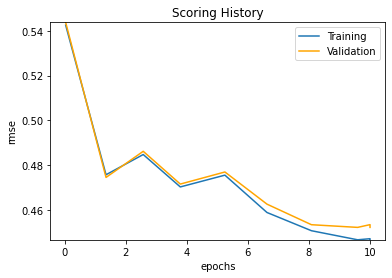

In [19]:
# Plot the scoring history
dl.plot()

In [20]:
# Number of epuchs
print("epochs = ", dl.params['epochs'])

epochs =  {'default': 10.0, 'actual': 10.0, 'input': 10.0}


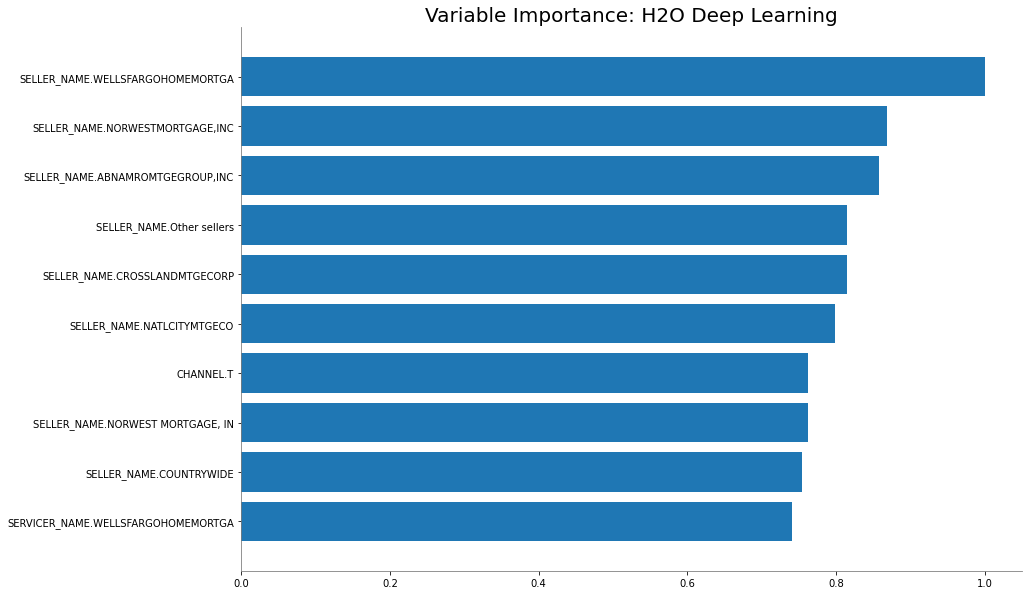

In [21]:
# Plot variable importance
dl.varimp_plot()

In [22]:
# Saving the model performance on the validation set
default_dl_per = dl.model_performance(valid)

### Task 6: Tune the XGBoost Model with H2O GridSearch

For more info about grid searching ► http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-hyperparameter-search

We will first try to find the max_depth for our XGBoost, as this is one of the most important parameters for an XGBoost model.

max_depth defines the number of nodms along the longest path from the start of the tree to the farthest leaf node.

In [23]:
# Hyperparameters and trainning
xgb = H2OXGBoostEstimator(model_id = 'xgb', 
                          ntrees = 300,
                          stopping_rounds = 3, #default
                          stopping_tolerance = 1e-3, #default
                          stopping_metric = "rmse", #default
                          seed = 42)

hyper_params = {'max_depth' : [5,7,9,10,12,13,15,20]}

grid_id = 'max_depth_grid'

search_criteria = { "strategy":"Cartesian"}

xgb_grid = H2OGridSearch(model = xgb, 
                         hyper_params = hyper_params,
                         grid_id = grid_id,
                         search_criteria = search_criteria)

%time xgb_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 36min 58s, sys: 3min 23s, total: 40min 22s
Wall time: 1h 1min 46s


In [24]:
# get the models trained by the GridSearch
sorted_xgb = xgb_grid.get_grid(sort_by = 'rmse', decreasing = False)
sorted_xgb.sorted_metric_table()

,,max_depth,model_ids,rmse
0,,7,max_depth_grid_model_2,0.4114569756454141
1,,5,max_depth_grid_model_1,0.4129006435219891
2,,9,max_depth_grid_model_3,0.41646343831685856
3,,10,max_depth_grid_model_4,0.4192768226314015
4,,12,max_depth_grid_model_5,0.423145826818501
5,,13,max_depth_grid_model_6,0.42570707596178287
6,,15,max_depth_grid_model_7,0.4302617202213125
7,,20,max_depth_grid_model_8,0.4389842538370232


1. sample_rate: Specifies the row sampling ratio of the training instance (x-axis). (Note that this method is sample without replacement.) For example, setting this value to 0.5 tells XGBoost to randomly collecte half of the data instances to grow trees. This value defaults to 1, and the range is 0.0 to 1.0. Higher values may improve training accuracy. Test accuracy improves when either columns or rows are sampled.

2. col_sample_rate: Specifies the column sampling rate (y-axis) for each split in each level. (Note that this method is sample without replacement.) This value defaults to 1.0, and the range is 0.0 to 1.0

3. col_sample_rate_per_tree: Specifies the column subsampling rate per tree. (Note that this method is sample without replacement.) This value defaults to 1.0 and can be a value from 0.0 to 1.0

Since we have 4 parameters in this grid search, we will be doing a random search; we will be using early stopping, and for our stopping criteria, we will set a limit of 100 models or 15 minutes. You can change these settings in the search_criteria_tune parameter for the grid search.

In [25]:
xgb = H2OXGBoostEstimator(model_id = 'xgb_grid', 
                          ntrees = 500, 
                          learn_rate = 0.25,
                          stopping_rounds = 3, #default
                          stopping_tolerance = 1e-3, #default
                          stopping_metric = "rmse", #default
                          seed = 42)

hyper_params = {'max_depth' : [5,6,7,9],
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 900, #15 min  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42}

xgb_grid = H2OGridSearch(xgb, hyper_params,
                         grid_id = 'random_grid',
                         search_criteria = search_criteria_tune)

%time xgb_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 8.2 s, sys: 800 ms, total: 9 s
Wall time: 15min 9s


In [26]:
# Results of the random search
sorted_xgb = xgb_grid.get_grid(sort_by = 'rmse', decreasing = False)
sorted_xgb.sorted_metric_table()

,,col_sample_rate,col_sample_rate_per_tree,max_depth,sample_rate,model_ids,rmse
0,,0.84,0.72,5,0.85,random_grid_model_1,0.41220602245190047
1,,0.71,0.7,5,0.94,random_grid_model_5,0.4128382164949427
2,,0.24,0.83,9,0.74,random_grid_model_4,0.41670168107322186
3,,0.29,0.72,6,0.35,random_grid_model_3,0.417072681050811
4,,0.81,0.73,7,0.4,random_grid_model_2,0.42037968701646145


In [27]:
# Retrieve the best model from the grid search
best_xgb_model = xgb_grid.models[0] 
best_xgb_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  random_grid_model_1


Model Summary: 


,,number_of_trees
0,,500.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.15646881108216415
RMSE: 0.39556138724876083
MAE: 0.2878390193327233
RMSLE: 0.046886189948925405
Mean Residual Deviance: 0.15646881108216415

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.16991380494561667
RMSE: 0.41220602245190047
MAE: 0.30041432663391077
RMSLE: 0.04889002337337007
Mean Residual Deviance: 0.16991380494561667

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-04-30 18:34:03,0.026 sec,0.0,6.708863,6.683679,45.008844,6.704750,6.679805,44.953673
1,,2021-04-30 18:34:05,1.864 sec,1.0,5.044730,5.012934,25.449306,5.040699,5.009208,25.408651
2,,2021-04-30 18:34:05,2.495 sec,2.0,3.799014,3.760007,14.432507,3.795582,3.756883,14.406440
3,,2021-04-30 18:34:06,3.146 sec,3.0,2.868788,2.819894,8.229947,2.865659,2.817115,8.212000
4,,2021-04-30 18:34:07,3.834 sec,4.0,2.177102,2.115053,4.739772,2.174498,2.112789,4.728444
5,,2021-04-30 18:34:07,4.495 sec,5.0,1.665550,1.586722,2.774058,1.662967,1.584533,2.765460
6,,2021-04-30 18:34:12,8.637 sec,17.0,0.465889,0.334825,0.217053,0.464964,0.335329,0.216192
7,,2021-04-30 18:34:17,14.309 sec,34.0,0.443063,0.325478,0.196305,0.443193,0.327033,0.196420
8,,2021-04-30 18:34:26,23.079 sec,60.0,0.430382,0.314778,0.185229,0.431248,0.316825,0.185975
9,,2021-04-30 18:34:40,37.059 sec,103.0,0.421453,0.307384,0.177622,0.423787,0.310541,0.179595



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,"SELLER_NAME.NORWESTMORTGAGE,INC",24009.591797,1.000000,0.193548
1,ORIGINAL_UPB,7951.083984,0.331163,0.064096
2,OCCUPANCY_STATUS.I,7126.965820,0.296838,0.057452
3,LOAN_PURPOSE.P,6445.682617,0.268463,0.051960
4,CREDIT_SCORE,5373.764160,0.223817,0.043319
5,ORIGINAL_LOAN_TO_VALUE,4029.250000,0.167818,0.032481
6,"SERVICER_NAME.ABNAMROMTGEGROUP,INC",3591.496826,0.149586,0.028952
7,SELLER_NAME.COUNTRYWIDE,3270.049561,0.136198,0.026361
8,POSTAL_CODE,3126.813965,0.130232,0.025206
9,SELLER_NAME.NATLCITYMTGECO,2963.057129,0.123411,0.023886



See the whole table with table.as_data_frame()


In [28]:
# Saving the model performance on the validation set
tuned_xgb_per = best_xgb_model.model_performance(valid)

In [29]:
# RMSE 
print("Default XGB RMSE: %.4f \nTuned XGB RMSE:%.4f" % (default_xgb_per.rmse(), tuned_xgb_per.rmse()))

Default XGB RMSE: 0.4244 
Tuned XGB RMSE:0.4122


In [30]:
# MAE
print("Default XGB MAE: %.4f \nTuned XGB MAE:%.4f" % (default_xgb_per.mae(), tuned_xgb_per.mae()))

Default XGB MAE: 0.3108 
Tuned XGB MAE:0.3004


### Task 7: Tune the Deep Learning model with H2O GridSearch

Two of the most important parameters of a Deep Learning model are the number of neurons in the hidden layers and the number of epochs. The parameter for both hidden neurons and layers is "hidden", and we can specify the hidden layer sizes.

In [31]:
# Tunning and training
dl = H2ODeepLearningEstimator(seed = 42, 
                              model_id = 'DL',
                              nfolds = 0,
                              keep_cross_validation_predictions = False,
                              epochs = 10,
                              activation = 'rectifier_with_dropout',
                              stopping_rounds = 5, #default
                              stopping_tolerance = 1e-3, #default
                              stopping_metric = "rmse") #default

hyper_params = {'hidden' : [[100, 100], [165, 165], [200,200], [330,330], 
                            [165, 200]],
                'hidden_dropout_ratios' : [[0,0], [0.01,0.01], [0.15,0.15], 
                                           [0.30, 0.30],[0.5,0.5]]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 900, #15 min  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42}

dl_grid = H2OGridSearch(model = dl, 
                        hyper_params = hyper_params,
                        grid_id = 'random_dl_grid',
                        search_criteria = search_criteria_tune)

%time dl_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 8 s, sys: 615 ms, total: 8.61 s
Wall time: 15min


In [32]:
# Results from the grid search.
hidden_per = dl_grid.get_grid(sort_by = 'rmse', decreasing = False)
hidden_per.sorted_metric_table()

,,hidden,hidden_dropout_ratios,model_ids,rmse
0,,"[165, 200]","[0.0, 0.0]",random_dl_grid_model_3,0.44716841633261006
1,,"[100, 100]","[0.5, 0.5]",random_dl_grid_model_2,0.4515212188796586
2,,"[165, 165]","[0.5, 0.5]",random_dl_grid_model_1,0.45706747864534597


model with the best score has a hidden_dropout_ratios of 0.01. so for the next grid search, we will use that value.

We will update the parameters with the values we just found and we will do a quick exploration for l2 and max_w2

1. l2: Specifies the L2 regularization to add stability and improve generalization; sets the value of many weights to smaller values. This value defaults to 0.

2. max_w2: Specifies the constraint for the squared sum of the incoming weights per unit. This value defaults to 3.4028235e38

In [33]:
# Getting the best model
dl = H2ODeepLearningEstimator(epochs = 10,
                              hidden = [165,200],
                              hidden_dropout_ratios = [0.0,0.0],
                              seed = 42,
                              model_id = 'DL',
                              activation = 'rectifier_with_dropout',
                              stopping_rounds = 3, 
                              stopping_tolerance = 1e-3, #default
                              stopping_metric = "rmse", #default
                              adaptive_rate = True)

hyper_params = {'max_w2'  : [1e38, 1e35, 1e36, 1e37, 1e34, 5e35],
                'l2'      : [1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 0],
               }

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 900, #15 min  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42 
                       }

dl_grid = H2OGridSearch(model = dl, 
                         hyper_params = hyper_params,
                         grid_id = 'random_dl_search',
                         search_criteria = search_criteria_tune)

%time dl_grid.train(x = x, y = y, training_frame = train, validation_frame = valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 7.97 s, sys: 613 ms, total: 8.59 s
Wall time: 15min


In [34]:
# Retrieving the results
dl_perf = dl_grid.get_grid(sort_by = 'rmse', decreasing = False)
dl_perf.sorted_metric_table()

,,l2,max_w2,model_ids,rmse
0,,1.0E-7,5.0E35,random_dl_search_model_2,0.4382983063040598
1,,0.001,1.0E34,random_dl_search_model_1,0.4649411436661688
2,,5.0E-4,1.0E38,random_dl_search_model_3,0.5503765892162031


In [35]:
# Getting the best model adjusting params from previous table
best_dl_model = dl_grid.models[0]

dl_checkpoint = H2ODeepLearningEstimator(checkpoint = best_dl_model.model_id,
                                         epochs = 200,
                                         hidden = [165,200],
                                         hidden_dropout_ratios = [0.0,0.0],
                                         adaptive_rate = True,
                                         l2 = 1.0e-7,
                                         max_w2 = 5e35,
                                         reproducible = True,                                     
                                         model_id = 'DL_checkpoint',
                                         activation = 'rectifier_with_dropout',
                                         distribution = 'auto',
                                         seed = 42,
                                         stopping_metric = 'RMSE',
                                         stopping_tolerance = 1e-3,
                                         stopping_rounds = 5)

%time dl_checkpoint.train(x = x, y = y, training_frame = train, validation_frame = valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 3.9 s, sys: 384 ms, total: 4.28 s
Wall time: 7min 34s


In [36]:
# Summary
dl_checkpoint

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL_checkpoint


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 60,791 weights/biases, 729.0 KB, 7,006,083 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,165,Input,0,,,,,,,,,
1,,2,165,RectifierDropout,0,0,1e-07,0.0545315,0.213513,0,-0.0225169,0.217645,-0.215387,0.303663
2,,3,200,RectifierDropout,0,0,1e-07,0.044882,0.042889,0,-0.0553149,0.143619,-0.162047,0.469052
3,,4,1,Linear,,0,1e-07,0.00126875,0.000891436,0,0.00720718,0.0965265,0.964912,1.09713e-154




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.16588999526164383
RMSE: 0.4072959553710837
MAE: 0.29554264145486064
RMSLE: 0.04841754979670431
Mean Residual Deviance: 0.16588999526164383

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.17321780362259534
RMSE: 0.41619443007156565
MAE: 0.3022720282708301
RMSLE: 0.04940931961450505
Mean Residual Deviance: 0.17321780362259534

Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2021-04-30 19:35:30,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-04-30 19:35:32,6 min 55.012 sec,2088 obs/sec,0.015979,1,5597.0,0.540979,0.292658,0.410515,0.109215,0.540927,0.292602,0.410147,0.123641
2,,2021-04-30 19:36:44,8 min 4.901 sec,7172 obs/sec,1.374599,85,481478.0,0.456079,0.208008,0.330599,0.366871,0.457127,0.208965,0.333123,0.374138
3,,2021-04-30 19:37:39,8 min 59.874 sec,8204 obs/sec,2.732656,169,957162.0,0.457669,0.209461,0.333159,0.362449,0.458158,0.209908,0.334117,0.371314
4,,2021-04-30 19:38:33,9 min 54.409 sec,8610 obs/sec,4.072562,252,1426488.0,0.442843,0.196110,0.328466,0.403086,0.445106,0.198120,0.331090,0.406622
5,,2021-04-30 19:39:29,10 min 49.595 sec,8958 obs/sec,5.508819,341,1929563.0,0.440240,0.193811,0.319894,0.410083,0.443120,0.196356,0.322337,0.411905
6,,2021-04-30 19:40:23,11 min 44.383 sec,9170 obs/sec,6.929768,429,2427276.0,0.434372,0.188679,0.324185,0.425705,0.438936,0.192665,0.327849,0.422959
7,,2021-04-30 19:41:19,12 min 40.015 sec,9315 obs/sec,8.370719,518,2931995.0,0.437282,0.191216,0.315966,0.417983,0.443286,0.196502,0.321145,0.411466
8,,2021-04-30 19:42:15,13 min 36.252 sec,9292 obs/sec,9.694797,600,3395777.0,0.434745,0.189003,0.319700,0.424716,0.439368,0.193044,0.323561,0.421823
9,,2021-04-30 19:42:33,13 min 53.580 sec,9288 obs/sec,10.002064,619,3503403.0,0.432355,0.186931,0.316479,0.431024,0.438298,0.192105,0.320446,0.424635



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,SELLER_NAME.WELLSFARGOHOMEMORTGA,1.000000,1.000000,0.012281
1,"SELLER_NAME.NORWESTMORTGAGE,INC",0.998609,0.998609,0.012264
2,"SELLER_NAME.ABNAMROMTGEGROUP,INC",0.945330,0.945330,0.011610
3,"SERVICER_NAME.ABNAMROMTGEGROUP,INC",0.929965,0.929965,0.011421
4,SELLER_NAME.Other sellers,0.896837,0.896837,0.011014
5,"SELLER_NAME.NORWEST MORTGAGE, IN",0.838642,0.838642,0.010299
6,OCCUPANCY_STATUS.O,0.831505,0.831505,0.010212
7,SELLER_NAME.BISHOPSGATERESIDENTI,0.800768,0.800768,0.009834
8,SELLER_NAME.NATLCITYMTGECO,0.792082,0.792082,0.009728
9,"SELLER_NAME.BANKOFAMERICA,NA",0.785161,0.785161,0.009643



See the whole table with table.as_data_frame()


In [37]:
# Let's see how our default model performance compares to the tuned one
tuned_dl_per = dl_checkpoint.model_performance(valid)
print("Default DL Model RMSE: %.4f \nTuned DL Model RMSE:%.4f" % (default_dl_per.rmse(), tuned_dl_per.rmse()))

Default DL Model RMSE: 0.4521 
Tuned DL Model RMSE:0.4162


In [38]:
# Now print the MAE of both models
print("Default DL Model MAE: %.4f \nTuned DL Model MAE:%.4f" % (default_dl_per.mae(), tuned_dl_per.mae()))

Default DL Model MAE: 0.3457 
Tuned DL Model MAE:0.3023


### Task 8: Test Set Performance

we will see how the models would perform on unseen data. Let's first print the final RMSE for both models. To do so, we need to evaluate the performance of our models on the test set.

In [39]:
dl_test_per = dl_checkpoint.model_performance(test)
xgb_test_per = best_xgb_model.model_performance(test)

In [40]:
# Printing RMSE
print("XGBoost Test RMSE: %.4f  \nDeep Learning Model Test RMSE: %.4f " % 
      (xgb_test_per.rmse(), dl_test_per.rmse()))

XGBoost Test RMSE: 0.4145  
Deep Learning Model Test RMSE: 0.4188 


In [41]:
# Printing MAE score
print("XGBoost Test MAE: %.4f  \nDeep Learning model Test MAE: %.4f " % 
      (xgb_test_per.mae(), dl_test_per.mae()))

XGBoost Test MAE: 0.3004  
Deep Learning model Test MAE: 0.3034 


In [44]:
# take a look at the first ten predictions of both models, compared to the actual interest value.
xgb_tuned_pred = best_xgb_model.predict(test) #get predictions from xgboost
test_rate_pred = test['ORIGINAL_INTEREST_RATE'].cbind(xgb_tuned_pred)#combined xgb predictions with actual interest rate
dl_tuned_pred = dl_checkpoint.predict(test)#get predictions from Deep Learning Model
test_rate_pred.cbind(dl_tuned_pred)

xgboost prediction progress: |████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


ORIGINAL_INTEREST_RATE,predict,predict0
6,6.85946,7.12726
6,5.70323,6.48198
7.25,7.04273,7.08946
7.125,7.0556,7.10863
7.125,7.1983,7.10485
7.75,7.03166,6.97342
6.99,6.9572,6.78092
7.125,7.2008,7.14446
7.25,6.97059,7.04672
7.125,6.85603,6.88644


Please note that the predict column has the predictions for the XGBoost model, and the predict0 column has the predictions for the Deep Learning model. As we can see in the image above, both predictions are close to the actual values. Although there might be some predictions that might be very off, the RMSE and MAE proved to us that both models make good predictions.